# Homework 2
Kristina, Marion and Alexandre

In [256]:
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import pandas as pd
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Global variables


In [262]:
max_rank = 200 # Keep only the first 200 universities

In [332]:
def plot_data_bar(data, ax, attr='', xdata='', title=''):
    
    ax.grid()
    if attr == 'index':
        ax.set_xlabel(data.index)
        sns.barplot(x=xdata, y=data.index, data=data, ax=ax, palette="Greens_r")
    else:
        ax.set_xlabel(data[attr])
        sns.barplot(x=xdata, y=data[attr], data=data, ax=ax, palette="Greens_r")

    ax.set_title(title, fontsize=14, fontweight='bold')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)

# First ranking - www.topuniversities.com

## Handle data

This ranking is also known as <i>QS University Ranking</i>.<br>
We see with <b>Postman</b> that a .txt file in a JSON format is loaded with the page. This file contains all universities with all the ranking informations displayed on the page.

In [297]:
URL_PATH_QS = 'https://www.topuniversities.com'
RANKING_DATA_URL_QS = URL_PATH_QS + '/sites/default/files/qs-rankings-data/357051.txt'
response_qs = requests.get(RANKING_DATA_URL_QS)  # HTTP GET request

raw_data_qs = json_normalize(response_qs.json(), 'data')

In [298]:
top200_qs = raw_data_qs[: max_rank]

Once we have the 200 top universities, we want to get more informations like :
- number of faculty members (international and total) 
- number of students (international and total)

These informations are not contained in the main page of the ranking, but in university details page.<br> 
Each university has a url attribute which allow us to make a GET request on each details page, in order to extract the data we need with BeautifulSoup.<br> This step can be slow because of the 200 GET requests we have to do.

In [287]:
def str_to_numeric(str):
    return int(str.replace(',',''))

def find_numbers(soup, attribute):
    try:
        div = soup.find('div', class_=attribute).find('div', class_="number")
        if div:
            return str_to_numeric(div.text)
        else:
            return 0
    except AttributeError:
        return 0

In [311]:
faculty_staff = []
international_staff = []
total_students = []
international_students = []

for i, row in top200_qs.iterrows():
    
    # Current url of the university
    url = row.url
    
    # Make to GET resquest in the details page
    response = requests.get(URL_PATH + url)
    soup = BeautifulSoup(response.text, 'html.parser') # Parse HTML page with BeaufitulSoup

    # Get number of total academic faculty staff
    total_faculty = find_numbers(soup, 'total faculty')
    # Get number of international academic staff
    inter_faculty = find_numbers(soup, 'inter faculty')
    # Get number of total students
    total_student = find_numbers(soup, 'total student')
    # Get number of international students
    total_inter = find_numbers(soup, 'total inter')
    
    faculty_staff.append(total_faculty)
    international_staff.append(inter_faculty)
    total_students.append(total_student)
    international_students.append(total_inter)
    
    
# Create new dataframes before concatenate with the main one  
total_faculty_staff_df = pd.DataFrame(faculty_staff, columns=['total_faculty_staff'])
international_faculty_staff_df = pd.DataFrame(international_staff, columns=['international_faculty_staff'])
total_students_df = pd.DataFrame(total_students, columns=['total_students'])
international_students_df = pd.DataFrame(international_students, columns=['international_students'])

# Concat the new information in the raw dataframe
top200_qs = pd.concat([top200_qs, total_faculty_staff_df, international_faculty_staff_df, total_students_df, international_students_df], axis=1)

In [312]:
# Data cleaning - Keep only useful information
top200_qs = top200_qs[['title', 'country', 'region', 'total_faculty_staff', 'international_faculty_staff', 'total_students', 'international_students']]

## Compute useful ratios

Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?<br>
<i>Note: the first ratio is the numbers of student for one faculty staff</i>

In [313]:
top200_qs['staff_student_ratio'] = (top200_qs.total_students / top200_qs.total_faculty_staff)   # (a)
top200_qs['international_student_ratio'] = (top200_qs.international_students / top200_qs.total_students) # (b)

### Top 10 universities

In [314]:
top10_qs_1 = top200_qs.sort_values(['staff_student_ratio'], ascending=True).head(10) # Top 10 universities - student/staff ratio
top10_qs_2 = top200_qs.sort_values(['international_student_ratio'], ascending=False).head(10) # Top 10 universities - international student ratio

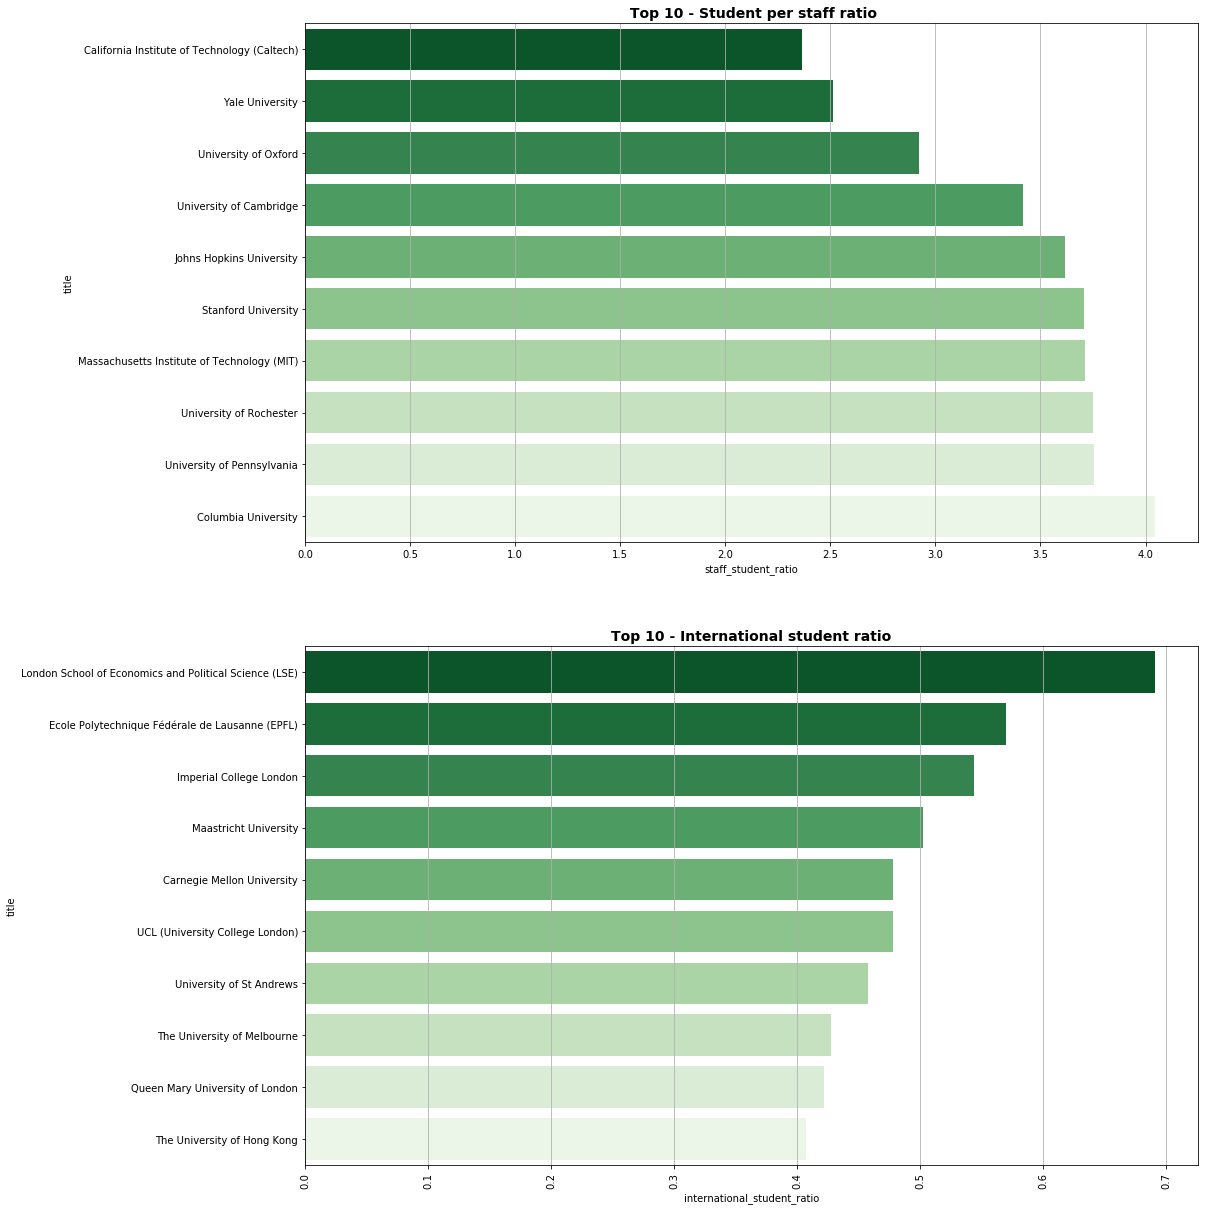

In [333]:
figure, axes = plt.subplots(2, 1, figsize=(16, 21))

plot_data_bar(top10_qs_1, axes[0], 'title', 'staff_student_ratio', ' Top 10 - Student per staff ratio')
plot_data_bar(top10_qs_2, axes[1], 'title', 'international_student_ratio', 'Top 10 - International student ratio')

#### Observations
TODO

### Top countries

In [335]:
# Group by country - mean
top200_qs_country_1 = top200_qs.groupby(['country'])[['staff_student_ratio']].mean()
top200_qs_country_top_1 = top200_qs_country_1.sort_values('staff_student_ratio', ascending=True)

# Group by country - mean
top200_qs_country_2 = top200_qs.groupby(['country'])[['international_student_ratio']].mean()
top200_qs_country_top_2 = top200_qs_country_2.sort_values('international_student_ratio', ascending=False)

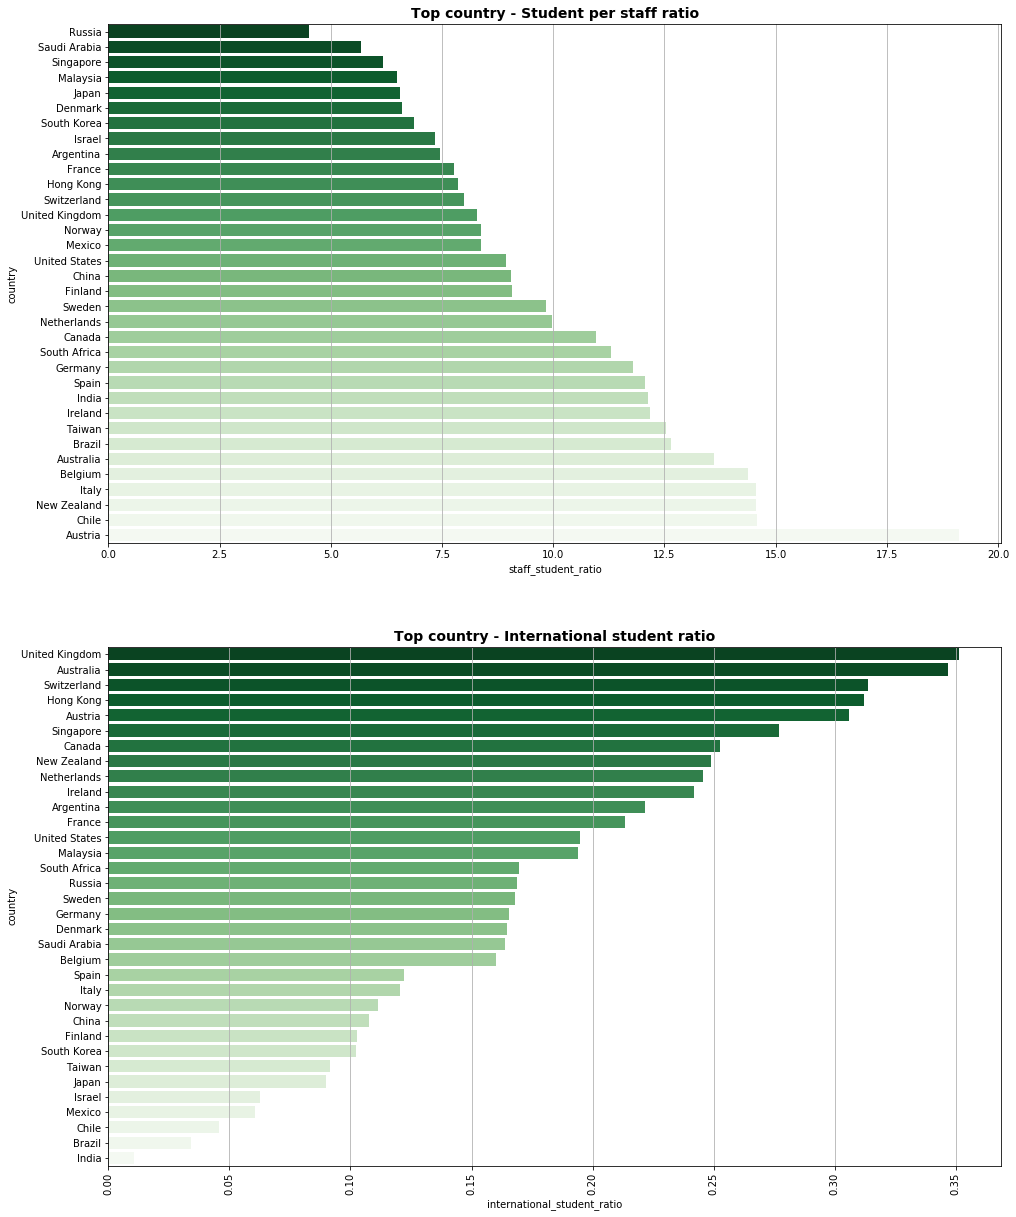

In [339]:
figure, axes = plt.subplots(2, 1, figsize=(16, 21))

plot_data_bar(top200_qs_country_top_1, axes[0], 'index', 'staff_student_ratio', 'Top country - Student per staff ratio')
plot_data_bar(top200_qs_country_top_2, axes[1], 'index', 'international_student_ratio', 'Top country - International student ratio')

#### Observations
TODO

### Top regions

In [337]:
# Group by region - mean
top200_qs_region_1 = top200_qs.groupby(['region'])[['staff_student_ratio']].mean()
top200_qs_region_top_1 = top200_qs_region_1.sort_values('staff_student_ratio', ascending=True)

# Group by region - mean
top200_qs_region_2 = top200_qs.groupby(['region'])[['international_student_ratio']].mean()
top200_qs_region_top_2 = top200_qs_region_2.sort_values('international_student_ratio', ascending=False)

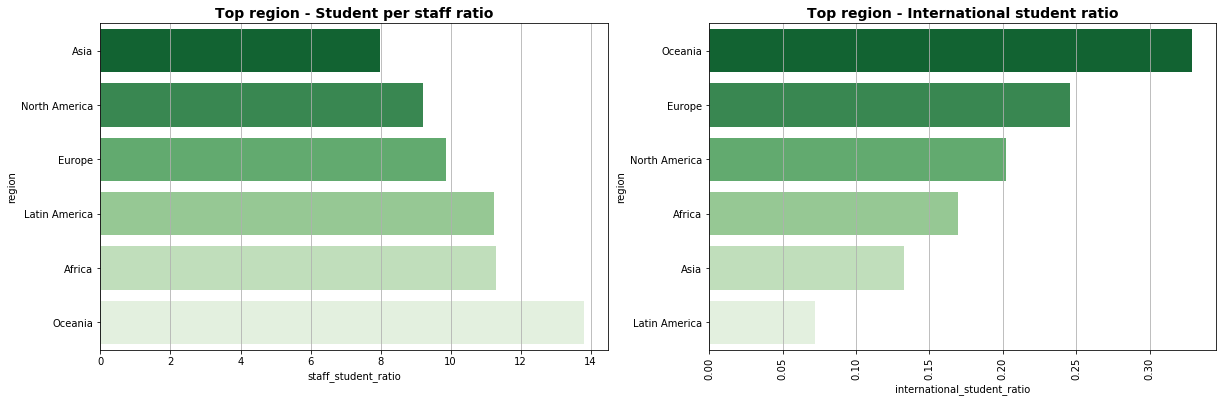

In [349]:
figure, axes = plt.subplots(1, 2, figsize=(20, 6))

plot_data_bar(top200_qs_region_top_1, axes[0], 'index', 'staff_student_ratio', 'Top region - Student per staff ratio')
plot_data_bar(top200_qs_region_top_2, axes[1], 'index', 'international_student_ratio', 'Top region - International student ratio')

#### Observations
TODO

# Second ranking - www.timeshighereducation.com

In [352]:
URL_PATH_THE = 'https://www.timeshighereducation.com'
RANKING_DATA_URL_THE = URL_PATH_THE + '/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
response_the = requests.get(RANKING_DATA_URL_THE)

raw_data_the = json_normalize(response_the.json(), 'data')

top200_the = raw_data_the[:max_rank]

#Add URL to dataframe
top200_the.head()

,aliases,location,member_level,name,nid,rank,rank_order,record_type,scores_citations,scores_citations_rank,...,scores_research,scores_research_rank,scores_teaching,scores_teaching_rank,stats_female_male_ratio,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,subjects_offered,url
0,University of Oxford,United Kingdom,0,University of Oxford,468,1,10,master_account,99.1,15,...,99.5,1,86.7,5,46 : 54,"20,409",38%,11.2,"Archaeology,Art, Performing Arts & Design,Biol...",/world-university-rankings/university-oxford
1,University of Cambridge,United Kingdom,0,University of Cambridge,470,2,20,master_account,97.5,29,...,97.8,3,87.8,3,45 : 55,"18,389",35%,10.9,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/university-cambridge
2,California Institute of Technology caltech,United States,0,California Institute of Technology,128779,=3,30,private,99.5,10,...,97.5,4,90.3,1,31 : 69,"2,209",27%,6.5,"Architecture,Biological Sciences,Business & Ma...",/world-university-rankings/california-institut...
3,Stanford University,United States,11,Stanford University,467,=3,40,private,99.9,4,...,96.7,5,89.1,2,42 : 58,"15,845",22%,7.5,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/stanford-university
4,Massachusetts Institute of Technology,United States,0,Massachusetts Institute of Technology,471,5,50,private,100.0,1,...,91.9,9,87.3,4,37 : 63,"11,177",34%,8.7,"Architecture,Art, Performing Arts & Design,Bio...",/world-university-rankings/massachusetts-insti...


In [147]:
top200_the = top200_the[['name', 'location', 'stats_number_students', 'stats_pc_intl_students', 'stats_student_staff_ratio', 'url']]
top200_the.head()

top200_the['stats_number_students'] = pd.to_numeric(top200_the['stats_number_students'].str.replace(',',''))
top200_the['stats_student_staff_ratio'] = pd.to_numeric(top200_the['stats_student_staff_ratio'])
top200_the['stats_pc_intl_students'] = pd.to_numeric(top200_the['stats_pc_intl_students'].str.replace('%', '')) / 100

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

In [148]:
#Sorting by first ratio - TOP 10
top10_1_the = top200_the.sort_values(['stats_student_staff_ratio'], ascending = 1).head(10)
top10_1_the

,name,location,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,url
105,Vanderbilt University,United States,12011,0.13,3.3,/world-university-rankings/vanderbilt-university
109,University of Copenhagen,Denmark,30395,0.14,4.1,/world-university-rankings/university-copenhagen
12,Johns Hopkins University,United States,15498,0.24,4.3,/world-university-rankings/johns-hopkins-unive...
11,Yale University,United States,12155,0.21,4.3,/world-university-rankings/yale-university
153,University of Rochester,United States,9636,0.29,4.3,/world-university-rankings/university-rochester
97,Emory University,United States,12649,0.19,4.4,/world-university-rankings/emory-university
16,Duke University,United States,15256,0.22,4.5,/world-university-rankings/duke-university
114,École Polytechnique,France,2799,0.36,5.1,/world-university-rankings/ecole-polytechnique
183,Scuola Normale Superiore di Pisa,Italy,515,0.07,5.2,/world-university-rankings/scuola-normale-supe...
101,University of Pittsburgh,United States,26367,0.10,5.9,/world-university-rankings/university-pittsburgh


In [149]:
#Sorting by second ratio - TOP 10
top10_2_the = top200_the.sort_values(['stats_pc_intl_students'], ascending = 0).head(10)
top10_2_the

,name,location,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,url
24,London School of Economics and Political Science,United Kingdom,10065,0.71,12.2,/world-university-rankings/london-school-econo...
178,University of Luxembourg,Luxembourg,4969,0.57,14.6,/world-university-rankings/university-luxembourg
37,École Polytechnique Fédérale de Lausanne,Switzerland,9928,0.55,11.2,/world-university-rankings/ecole-polytechnique...
7,Imperial College London,United Kingdom,15857,0.55,11.4,/world-university-rankings/imperial-college-lo...
102,Maastricht University,Netherlands,16727,0.50,18.0,/world-university-rankings/maastricht-university
15,University College London,United Kingdom,30304,0.49,10.5,/world-university-rankings/university-college-...
143,University of St Andrews,United Kingdom,9005,0.48,13.0,/world-university-rankings/university-st-andrews
23,Carnegie Mellon University,United States,12676,0.45,13.5,/world-university-rankings/carnegie-mellon-uni...
120,Queen Mary University of London,United Kingdom,15405,0.45,13.3,/world-university-rankings/queen-mary-universi...
39,University of Hong Kong,Hong Kong,18364,0.42,18.0,/world-university-rankings/university-hong-kong


In [150]:
def plot_data_bar_the(data, ax, xdata='', ylabel='', title=''):
    ax.set_xlabel(data.index)
    ax.set_ylabel(ylabel)
    ax.grid()
    ax.set_title(title, fontsize=14, fontweight='bold')
    sns.barplot(x=xdata, y=data.index, data=data, ax=ax, palette="Greens_r")
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    
def plot_data_bar_top10_the(data, ax, xdata='', ylabel='', title=''):
    ax.set_xlabel(data.name)
    ax.set_ylabel(ylabel)
    ax.grid()
    ax.set_title('Top 10 - ' + title, fontsize=14, fontweight='bold')
    sns.barplot(x=xdata, y=data.name, data=data, ax=ax, palette="Greens_r")
    locs, labels = plt.xticks(rotation=90)
    plt.setp(labels, rotation=90)

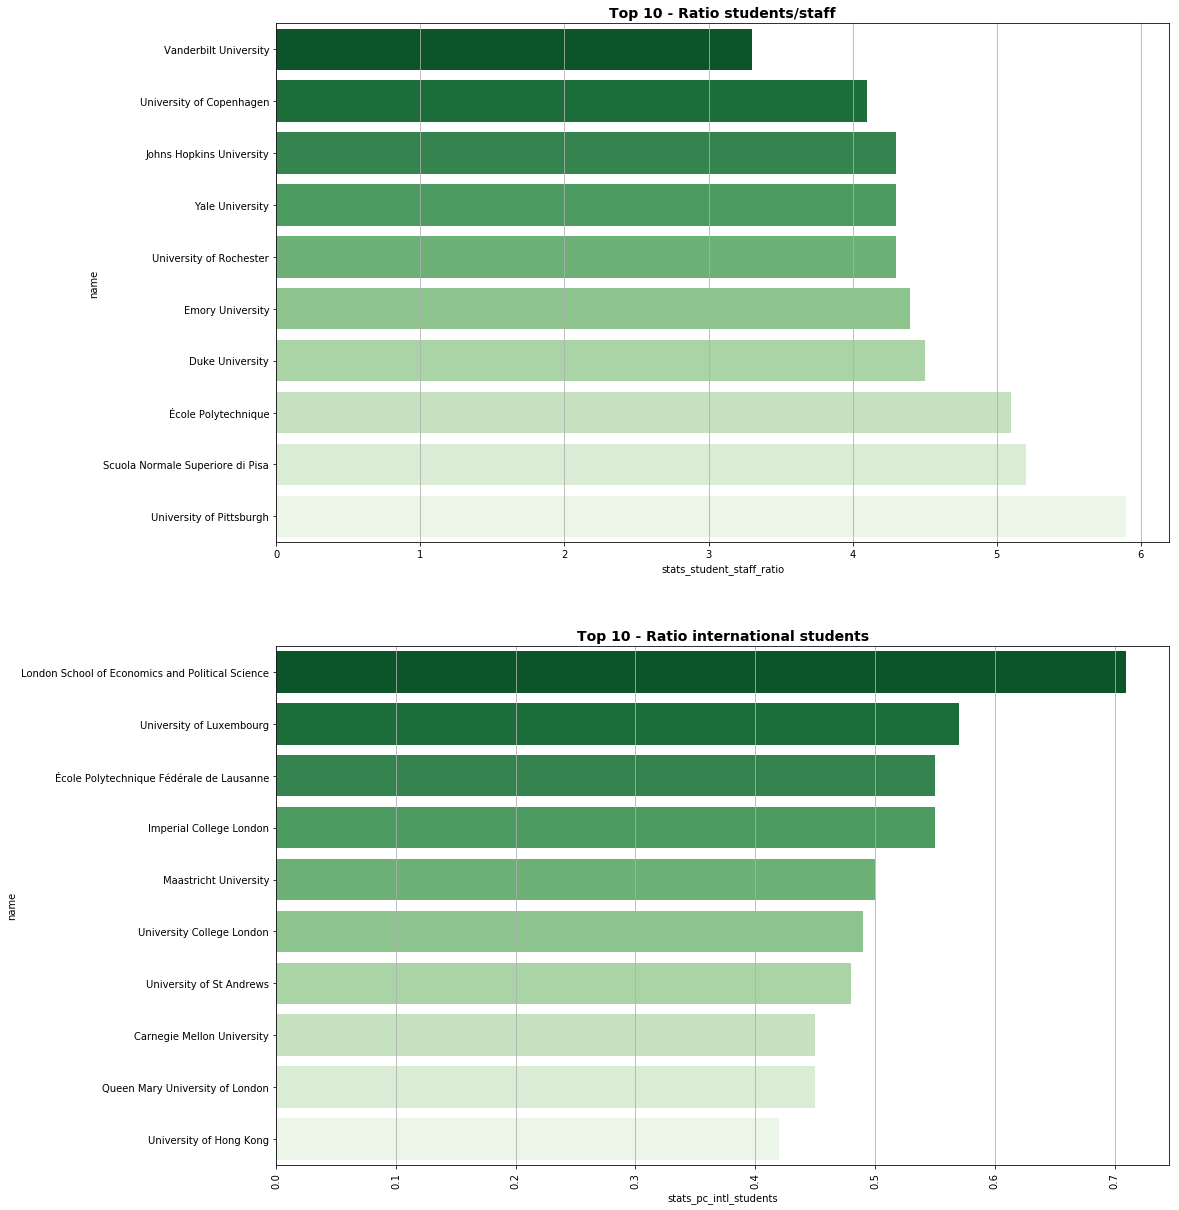

In [151]:
figure, axes = plt.subplots(2, 1, figsize=(16, 21))

plot_data_bar_top10_the(top10_1_the, axes[0], xdata='stats_student_staff_ratio', title='Ratio students/staff')
plot_data_bar_top10_the(top10_2_the, axes[1], xdata='stats_pc_intl_students', title='Ratio international students')

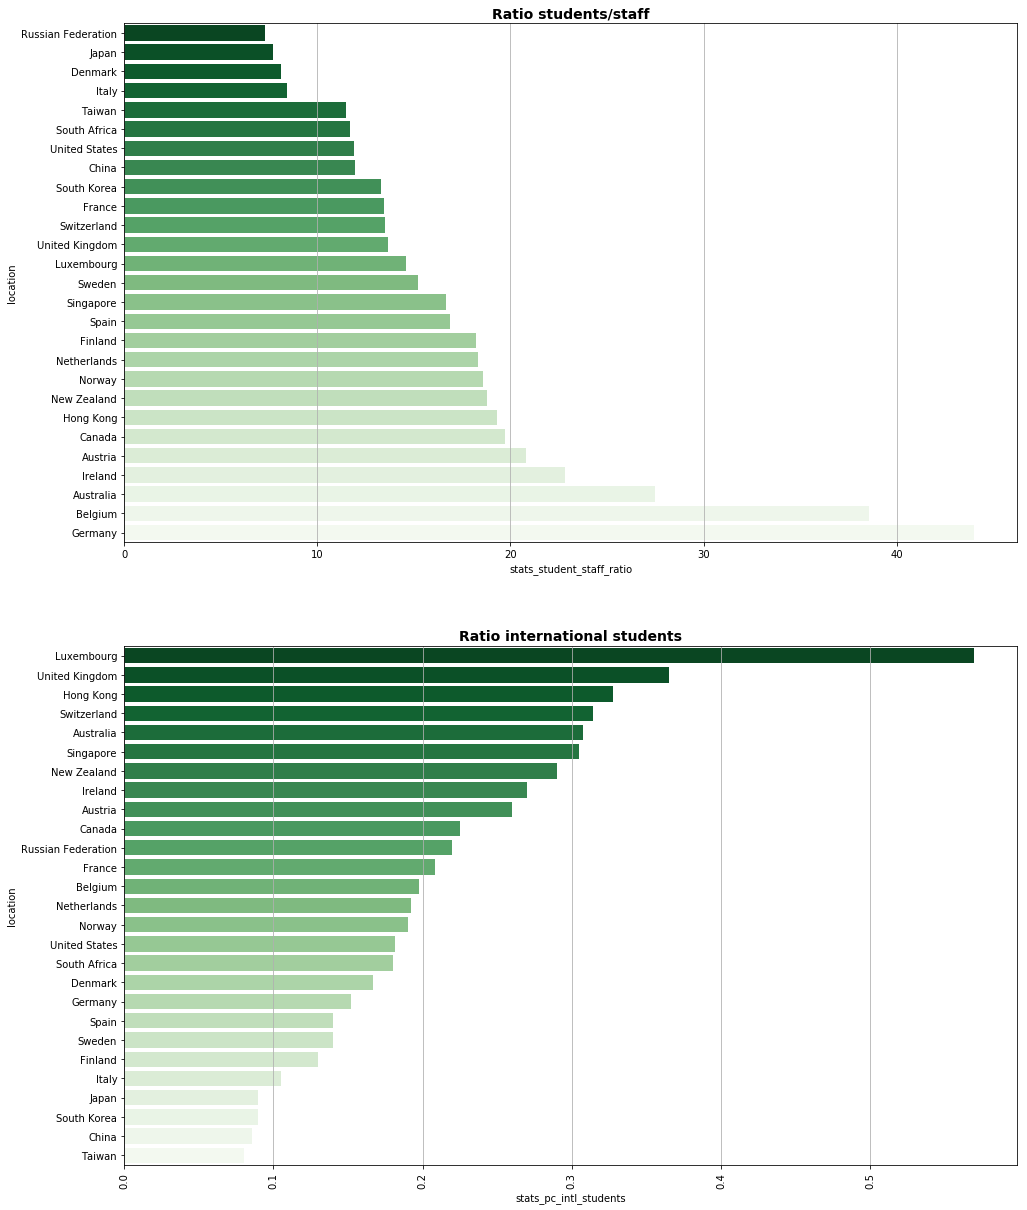

In [152]:
# Group by country - mean
data_1_the = top200_the.groupby(['location'])[['stats_student_staff_ratio']].mean()
data_sorted_1_the = data_1_the.sort_values('stats_student_staff_ratio', ascending=1)

# Group by country - mean
data_2_the = top200_the.groupby(['location'])[['stats_pc_intl_students']].mean()
data_sorted_2_the = data_2_the.sort_values('stats_pc_intl_students', ascending=0)

figure, axes = plt.subplots(2, 1, figsize=(16, 21))

plot_data_bar_the(data_sorted_1_the, axes[0], xdata='stats_student_staff_ratio', title='Ratio students/staff')
plot_data_bar_the(data_sorted_2_the, axes[1], xdata='stats_pc_intl_students', title='Ratio international students')

In [199]:
from difflib import SequenceMatcher

def similar(a, b):
    a = a.lower()
    b = b.lower()
    
    return SequenceMatcher(None, a, b)

def sanitize_data(c):
    return c.str.lower(). \
    str.replace('universitat','university'). \
    str.replace('universitaet','university'). \
    str.replace('universidad', 'university'). \
    str.replace('universite','university'). \
    str.replace('technische','technology'). \
    str.replace('institute',''). \
    str.replace('science',''). \
    str.replace(r'\(.*\)', ''). \
    str.replace('the ',''). \
    str.replace(' of ',''). \
    str.replace(' at ',''). \
    str.replace(' de ',''). \
    str.replace(' et ',''). \
    str.replace(' and ',''). \
    str.replace(r',|\.',''). \
    str.replace(' ',''). \
    str.replace('\'','')

In [200]:
top200_completed_cp = top200_completed.copy()
top200_the_cp = top200_the.copy()

top200_completed_cp['rank_1'] = top200_completed_cp.index + 1
top200_the_cp['rank_2'] = top200_the_cp.index + 1

top200_completed_cp['name_id'] = sanitize_data(top200_completed_cp.title)
top200_the_cp['name_id'] = sanitize_data(top200_the_cp.name)

In [201]:
top200_completed_cp

,title,country,region,total_faculty_staff,international_faculty_staff,total_students,international_students,ratio staff/student,ratio international student,rank_1,name_id
0,Massachusetts Institute of Technology (MIT),United States,North America,2982,1679,11067,3717,3.711268,0.335863,1,massachusettstechnology
1,Stanford University,United States,North America,4285,2042,15878,3611,3.705484,0.227422,2,stanforduniversity
2,Harvard University,United States,North America,4350,1311,22429,5266,5.156092,0.234785,3,harvarduniversity
3,California Institute of Technology (Caltech),United States,North America,953,350,2255,647,2.366212,0.286918,4,californiatechnology
4,University of Cambridge,United Kingdom,Europe,5490,2278,18770,6699,3.418944,0.356899,5,universitycambridge
5,University of Oxford,United Kingdom,Europe,6750,2964,19720,7353,2.921481,0.372870,6,universityoxford
6,UCL (University College London),United Kingdom,Europe,6345,2554,31080,14854,4.898345,0.477928,7,ucl
7,Imperial College London,United Kingdom,Europe,3930,2071,16090,8746,4.094148,0.543567,8,imperialcollegelondon
8,University of Chicago,United States,North America,2449,635,13557,3379,5.535729,0.249244,9,universitychicago
9,ETH Zurich - Swiss Federal Institute of Techno...,Switzerland,Europe,2477,1886,19815,7563,7.999596,0.381681,10,ethzurich-swissfederaltechnology


In [202]:
for i, row in top200_completed_cp.copy().iterrows():
    max_accuracy = -1.
    accurate_name = 'NaN'
    for name in top200_the_cp.name_id:
        accuracy = similar(row.name_id, name).ratio()
        if (accuracy > max_accuracy) & (accuracy > 0.85):
            max_accuracy = accuracy
            accurate_name = name
            
    top200_completed_cp.at[i, 'max_accuracy'] = max_accuracy
    top200_completed_cp.at[i, 'name_id'] = accurate_name

In [231]:
final_top200 = pd.merge(top200_completed_cp, top200_the_cp, left_on='name_id', right_on='name_id')

In [232]:
final_top200

,title,country,region,total_faculty_staff,international_faculty_staff,total_students,international_students,ratio staff/student,ratio international student,rank_1,name_id,max_accuracy,name,location,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,url,rank_2
0,Massachusetts Institute of Technology (MIT),United States,North America,2982,1679,11067,3717,3.711268,0.335863,1,massachusettstechnology,1.000000,Massachusetts Institute of Technology,United States,11177,0.34,8.7,/world-university-rankings/massachusetts-insti...,5
1,Stanford University,United States,North America,4285,2042,15878,3611,3.705484,0.227422,2,stanforduniversity,1.000000,Stanford University,United States,15845,0.22,7.5,/world-university-rankings/stanford-university,4
2,Harvard University,United States,North America,4350,1311,22429,5266,5.156092,0.234785,3,harvarduniversity,1.000000,Harvard University,United States,20326,0.26,8.9,/world-university-rankings/harvard-university,6
3,California Institute of Technology (Caltech),United States,North America,953,350,2255,647,2.366212,0.286918,4,californiatechnology,1.000000,California Institute of Technology,United States,2209,0.27,6.5,/world-university-rankings/california-institut...,3
4,University of Cambridge,United Kingdom,Europe,5490,2278,18770,6699,3.418944,0.356899,5,universitycambridge,1.000000,University of Cambridge,United Kingdom,18389,0.35,10.9,/world-university-rankings/university-cambridge,2
5,University of Oxford,United Kingdom,Europe,6750,2964,19720,7353,2.921481,0.372870,6,universityoxford,1.000000,University of Oxford,United Kingdom,20409,0.38,11.2,/world-university-rankings/university-oxford,1
6,Imperial College London,United Kingdom,Europe,3930,2071,16090,8746,4.094148,0.543567,8,imperialcollegelondon,1.000000,Imperial College London,United Kingdom,15857,0.55,11.4,/world-university-rankings/imperial-college-lo...,8
7,University of Chicago,United States,North America,2449,635,13557,3379,5.535729,0.249244,9,universitychicago,1.000000,University of Chicago,United States,13525,0.25,6.2,/world-university-rankings/university-chicago,9
8,ETH Zurich - Swiss Federal Institute of Techno...,Switzerland,Europe,2477,1886,19815,7563,7.999596,0.381681,10,ethzurich–swissfederaltechnologyzurich,0.885714,ETH Zurich – Swiss Federal Institute of Techno...,Switzerland,19233,0.38,14.6,/world-university-rankings/eth-zurich-swiss-fe...,10
9,"Nanyang Technological University, Singapore (NTU)",Singapore,Asia,4338,2993,25738,7251,5.933149,0.281724,11,nanyangtechnologicaluniversitysingapore,1.000000,"Nanyang Technological University, Singapore",Singapore,25499,0.31,16.3,/world-university-rankings/nanyang-technologic...,52


In [233]:
#Trying to see correlation between total rank and ratio_staff/student
final_top200[['rank_1', 'ratio staff/student']].rank().corr()

,rank_1,ratio staff/student
rank_1,1.000000,0.423037
ratio staff/student,0.423037,1.000000


In [234]:
#Trying to see correlation between total rank and rank international students
final_top200[['rank_1', 'ratio international student']].rank().corr()

,rank_1,ratio international student
rank_1,1.000000,-0.320806
ratio international student,-0.320806,1.000000


In [235]:
#Trying to see correlation between total rank and rank international students
final_top200[['rank_1', 'rank_2']].rank().corr()

,rank_1,rank_2
rank_1,1.000000,0.735029
rank_2,0.735029,1.000000


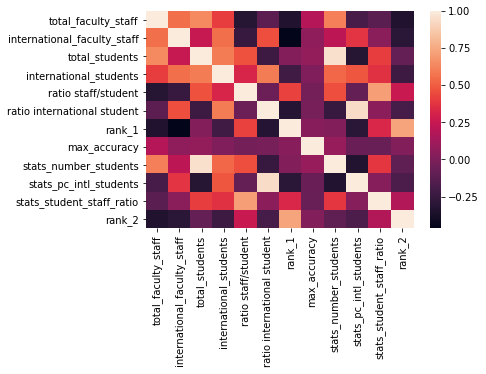

In [236]:
#We can see correlation between columns
import seaborn as sns

corr = final_top200.select_dtypes(['number']).rank().corr()

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [253]:
fiability_1 = 0.6
fiability_2 = 0.4

final_top200_ratio = final_top200.copy()
final_top200_ratio['rank_ratio'] = fiability_1 * (final_top200_ratio.rank_1 / final_top200_ratio.size) + fiability_2 * (final_top200_ratio.rank_2 / final_top200_ratio.size)

cc = final_top200_ratio.sort_values('rank_ratio').reset_index(drop=True)
cc.index += 1

In [255]:
#Final TOP200 with my assumtions
cc[['title']]

,title
1,Massachusetts Institute of Technology (MIT)
2,Stanford University
3,California Institute of Technology (Caltech)
4,University of Cambridge
5,University of Oxford
6,Harvard University
7,Imperial College London
8,University of Chicago
9,ETH Zurich - Swiss Federal Institute of Techno...
10,Princeton University
